In [2]:
import matplotlib.pyplot as plt
import glob
from PIL import Image, ImageDraw, ImageFont
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn.model_selection import train_test_split
import albumentations as A

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

at above we import all the libraries requaredaa

In [23]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Load the data table
col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
df = pd.read_csv('data2.txt', sep="\s+", names=col_names, header=None)
df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)

images_path = "all-mias"

all_images = []
all_labels = []
all_groups = []

for filename in sorted(os.listdir(images_path)):
    if filename.lower().endswith('.pgm'):
        ref_num = os.path.splitext(filename)[0]
        record = df[df['REFNUM'] == ref_num]

        if not record.empty:
            full_path = os.path.join(images_path, filename)
            img_array = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)

            # Apply CLAHE to enhance contrast
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            img_eq = clahe.apply(img_array)

            # Resize the entire image to 256x256 (no ROI used)
            resized_img = cv2.resize(img_eq, (256, 256), interpolation=cv2.INTER_AREA)

            label = record['CANCER'].iloc[0]
            all_images.append(resized_img)
            all_labels.append(label)
            all_groups.append(ref_num[:-1])  # remove last char if needed for grouping

print("Data has been loaded successfully.")
print(f"Total images: {len(all_images)}")
print(f"Total labels: {len(all_labels)}")



Data has been loaded successfully.
Total images: 324
Total labels: 324


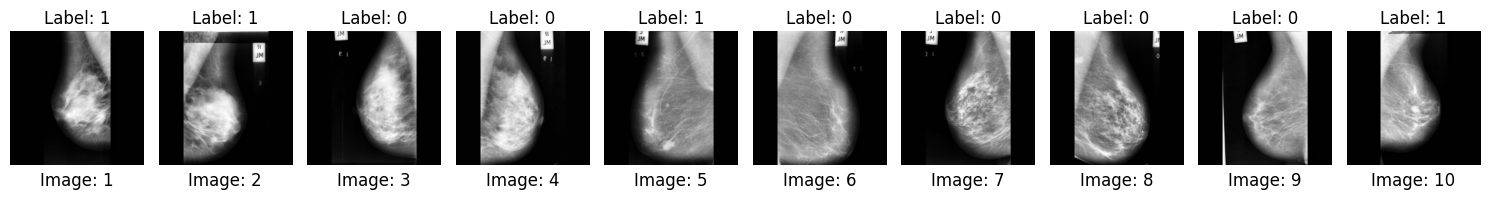

In [33]:
import matplotlib.pyplot as plt

# Display 5 images with labels underneath
plt.figure(figsize=(15, 5))  # wide figure

for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    ax.imshow(all_images[i], cmap='gray')
    plt.titlx(f"Label: {all_labels[i]}")
    plt.axis('off')
    ax.axis('off')  # remove axis ticks
    
    # Add label text BELOW the image
    label = all_labels[i]
    label_text = f"Image: {i+1}"
    
    # Use plt.text with transform=ax.transAxes to place text relative to the axes
    ax.text(0.5, -0.15, label_text, fontsize=12, ha='center', transform=ax.transAxes)

# plt.suptitle("First 5 Images with Labels Below", fontsize=16)
plt.tight_layout()
plt.show()


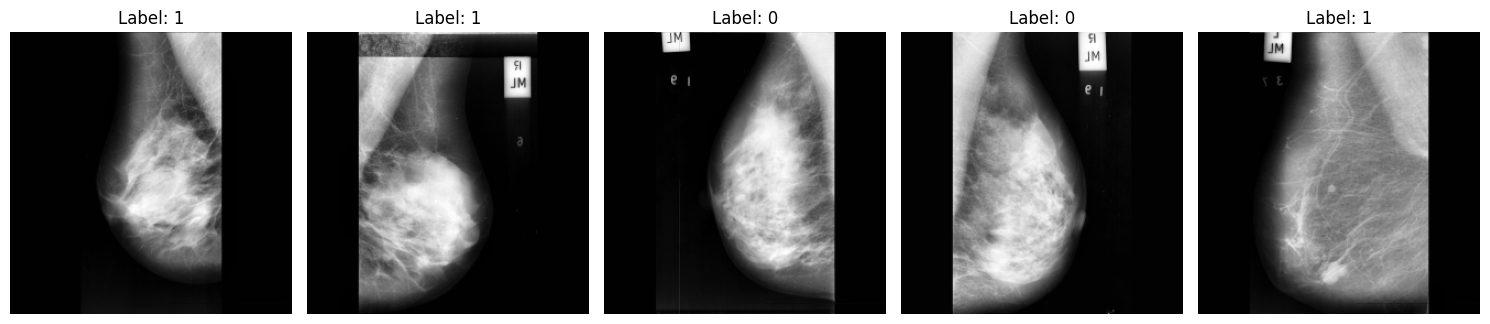

In [10]:
# Show first 5 images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(all_images[i], cmap='gray')
    plt.title(f"Label: {all_labels[i]}")
    plt.axis('off')
    
    label_text = "Cancer" if label == 1 else "Normal"
    plt.xlabel(label_text, fontsize=12)
    label = all_labels[i]
    plt.xlabel("label", fontsize=12)
    plt.xlabel(f"Label: {label}", fontsize=12)
# plt.suptitle("First 5 Full Images (No ROI)", fontsize=16)
plt.tight_layout()
plt.show()


In [6]:
# # --- Configuration ---
# RAW_IMG_PATH = "all-mias"  # The folder with your mixed-up .pgm images
# MASTER_CSV_PATH = "data2.txt" # Your master data file
# OUTPUT_DATASET_PATH = "dataset_for_training" # Where we will create the sorted folders

# # --- Step 1: Load and Prepare the Master DataFrame ---
# print("Loading and preparing the master DataFrame...")
# col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
# df = pd.read_csv(MASTER_CSV_PATH, sep="\s+", names=col_names, header=None)

# # Create the binary 'CANCER' label (1 for any abnormality, 0 for normal)
# df['CANCER'] = df['CLASS'].apply(lambda x: 0 if x == 'NORM' else 1)
# print(f"DataFrame loaded. Total images: {len(df)}. Cancer cases: {df['CANCER'].sum()}.")


# # --- Step 2: Split the DataFrame into Training and Validation Sets ---
# # We split the DataFrame first to ensure a clean separation of data.
# # stratify=df['CANCER'] ensures both train and validation sets have a similar percentage of cancer cases.
# print("Splitting DataFrame into training and validation sets...")
# train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['CANCER'])
# print(f"Training set size: {len(train_df)}, Validation set size: {len(validation_df)}")


# # --- Step 3: The Core Processing Function ---
# def create_dataset(dataframe, source_img_folder, output_folder):
#     """
#     Reads a dataframe, processes the corresponding images, and saves them
#     into 'cancer' and 'normal' subdirectories.
#     """
#     print(f"Processing images for: {output_folder}")
#     # Create the output directories if they don't exist
#     cancer_path = os.path.join(output_folder, 'cancer')
#     normal_path = os.path.join(output_folder, 'normal')
#     os.makedirs(cancer_path, exist_ok=True)
#     os.makedirs(normal_path, exist_ok=True)

#     for index, row in dataframe.iterrows():
#         refnum = row['REFNUM']
#         is_cancer = row['CANCER']
#         image_filename = f"{refnum}.pgm"
#         image_filepath = os.path.join(source_img_folder, image_filename)

#         if not os.path.exists(image_filepath):
#             print(f"Warning: Image file not found for {refnum}, skipping.")
#             continue

#         # Load the image in grayscale
#         img = cv2.imread(image_filepath, cv2.IMREAD_GRAYSCALE)
#         if img is None:
#             print(f"Warning: Could not read image {image_filename}, skipping.")
#             continue

#         # If it's an abnormal case, extract the ROI
#         if is_cancer == 1 and pd.notna(row['X']):
#             # Use a mask to extract the circular ROI
#             x, y, r = int(row['X']), int(row['Y']), int(row['RADIUS'])
#             y_adj = 1024 - y # Adjust y-coordinate
#             mask = np.zeros_like(img)
#             cv2.circle(mask, (x, y_adj), r, 255, -1)
            
#             # Get the bounding box of the circle to crop the image
#             x_min, x_max = max(0, x - r), min(img.shape[1], x + r)
#             y_min, y_max = max(0, y_adj - r), min(img.shape[0], y_adj + r)
            
#             # Crop the image and the mask
#             cropped_img = img[y_min:y_max, x_min:x_max]
#             cropped_mask = mask[y_min:y_max, x_min:x_max]
            
#             # Apply mask to the cropped image
#             final_roi = cv2.bitwise_and(cropped_img, cropped_img, mask=cropped_mask)
            
#             # Save the processed ROI
#             output_filepath = os.path.join(cancer_path, f"{refnum}_roi.png")
#             cv2.imwrite(output_filepath, final_roi)

#         # If it's a normal case, extract a central patch
#         elif is_cancer == 0:
#             # Extract a 224x224 central patch as a sample of normal tissue
#             h, w = img.shape
#             crop_size = 224
#             start_h, start_w = h // 2 - crop_size // 2, w // 2 - crop_size // 2
#             normal_patch = img[start_h : start_h + crop_size, start_w : start_w + crop_size]

#             # Save the normal patch
#             output_filepath = os.path.join(normal_path, f"{refnum}_normal_patch.png")
#             cv2.imwrite(output_filepath, normal_patch)

# # --- Step 4: Run the dataset creation for both sets ---
# create_dataset(train_df, RAW_IMG_PATH, os.path.join(OUTPUT_DATASET_PATH, 'train'))
# create_dataset(validation_df, RAW_IMG_PATH, os.path.join(OUTPUT_DATASET_PATH, 'validation'))

# print("\nDataset creation complete!")
# print(f"Your training-ready dataset is located in: {OUTPUT_DATASET_PATH}")

Loading and preparing the master DataFrame...
DataFrame loaded. Total images: 325. Cancer cases: 118.
Splitting DataFrame into training and validation sets...
Training set size: 260, Validation set size: 65
Processing images for: dataset_for_training\train
Processing images for: dataset_for_training\validation

Dataset creation complete!
Your training-ready dataset is located in: dataset_for_training


In [2]:
df = pd.read_csv('data2.txt', sep=" ").drop('Unnamed: 7', axis=1)
df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)
df.head(5)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,CANCER
0,mdb001,G,CIRC,B,535.0,425.0,197.0,1
1,mdb002,G,CIRC,B,522.0,280.0,69.0,1
2,mdb003,D,NORM,NaN,NaN,NaN,NaN,0
3,mdb004,D,NORM,NaN,NaN,NaN,NaN,0
4,mdb005,F,CIRC,B,500.0,145.0,65.0,1


In [3]:
def data_labeling(img_files, txt_path):
    full_data = []
    cordinates = []
    # count_cancer = 0
    # img_coordinate = defaultdict(list)
    
    for i, filename in enumerate(sorted(os.listdir(img_files))): # Opens the image file and go throuth all the image 
        if filename.endswith(".pgm"): # display only if the image is pgm
            image_path = os.path.join(img_files, filename) # Getting the Image path EX => all-mias\mdb001.pgm
            text = txt_file[i].strip() # spliting the data in the text file 
            pairing = {"Image": image_path, "Text": text} # putting both image and the text in the dictinory 
            full_data.append(pairing) # adding all the data to the list 

    for pairing in full_data:
        txt_value = pairing['Text'] # ceperating the image with the text
        img_value = pairing['Image']
        
        img = cv2.imread(img_value) # creating the array
        txt_parts = txt_value.split() # spleting text in to multiple in array so to filter the data which they have the cordinates
        
        # Converting the image to GRAY and then to RGB and prepare for drawing
        img_gray = cv2.imread(img_value, cv2.IMREAD_GRAYSCALE)  
        img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
               
        # Cheking if the text line contain the cordinate or not
        if len(txt_parts) == 7 and img is not None: 
            # Getting the cordinate for each image one by one 

            get_txt_data = txt_parts[4] + " " + txt_parts[5] + " " +txt_parts[6] # joining the X , Y , R
            x, y, r = map(int, get_txt_data.split())
            
            y_adj = 1024 - y
            cv2.circle(img_rgb, (x, y_adj), r, (0,255,0), 3)
            
            mask = np.zeros(img_rgb.shape[:2], dtype=np.uint8)
            cv2.circle(mask, (x, y_adj), r, 255, -1)
            roi = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

            # plt.imshow(img_rgb, cmap='gray')
            # plt.title("Example .pgm Image")
            # plt.axis('off')  # Hide axis ticks
            # plt.show()

# reading the Image file 
images_path = "all-mias"

# reading the txt file 
txt_path = "data2.txt"
with open(txt_path, "r") as file:
    txt_file = file.readlines()[1:]

data_labeling(images_path, txt_path)


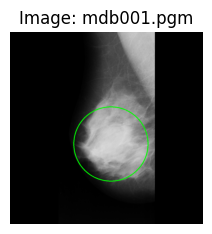

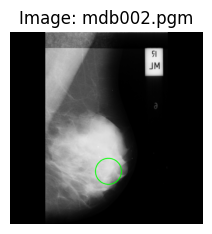

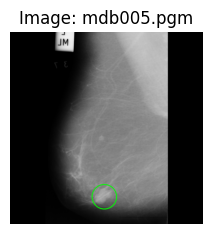

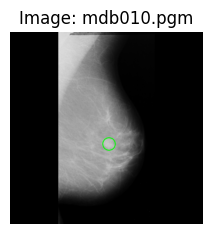

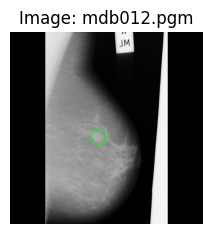

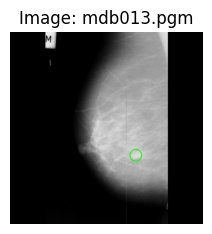

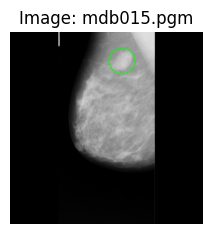

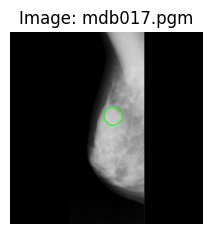

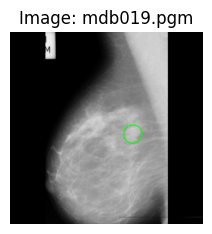

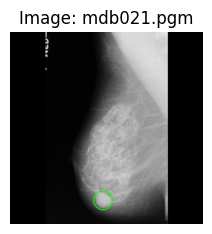

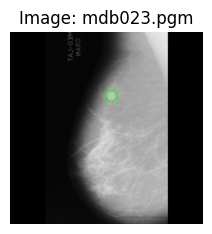

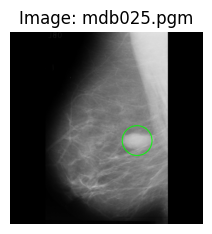

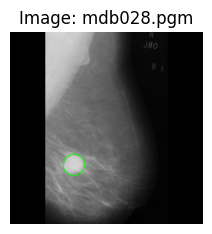

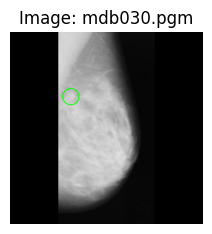

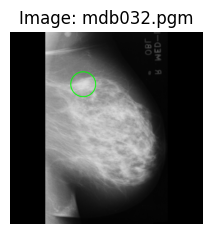

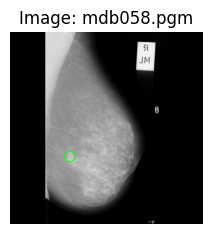

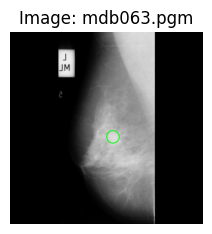

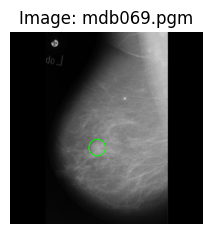

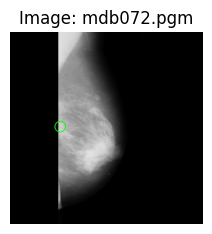

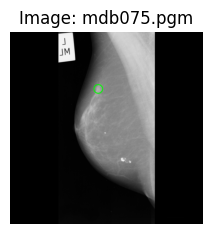

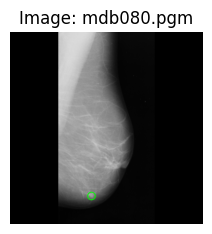

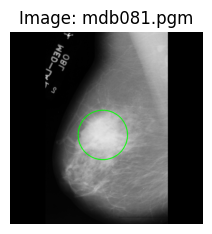

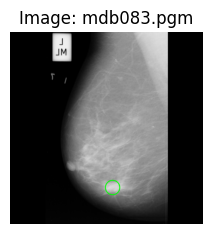

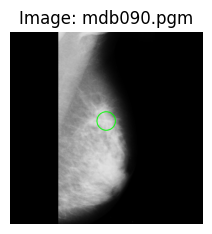

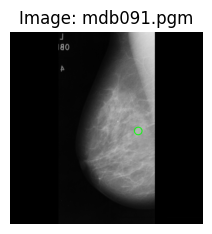

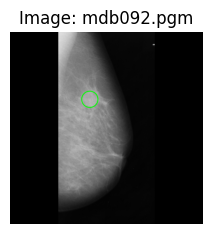

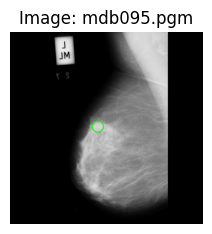

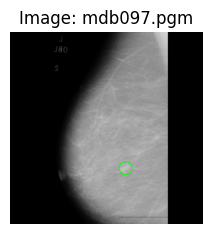

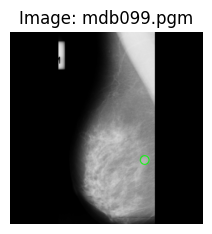

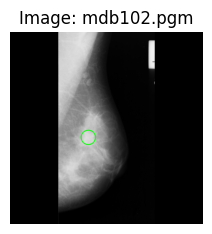

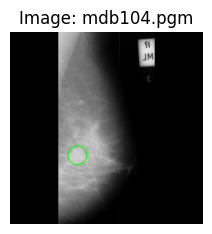

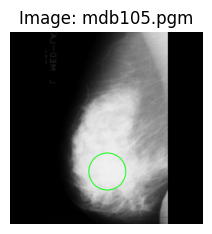

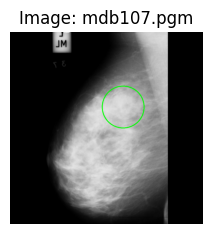

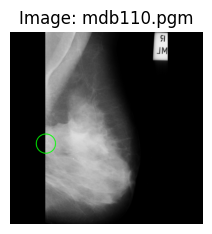

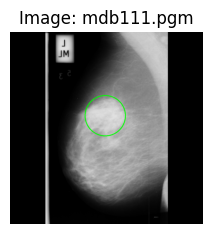

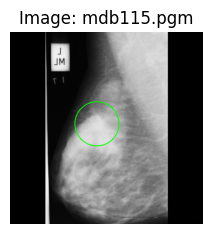

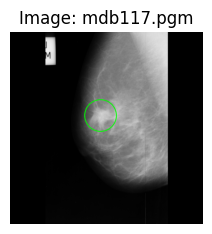

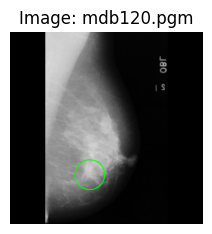

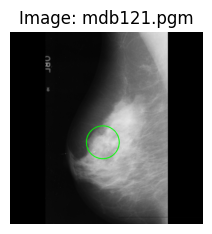

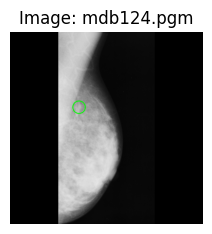

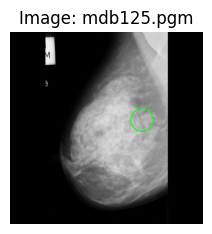

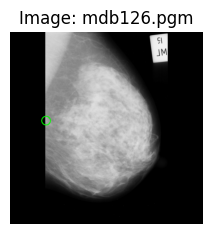

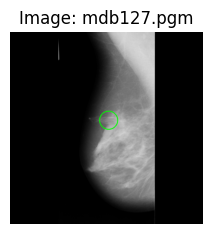

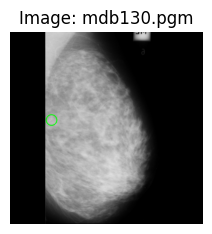

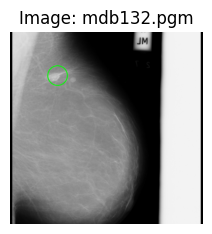

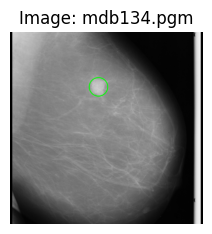

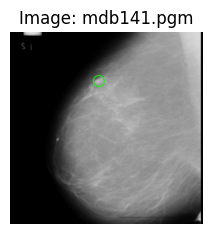

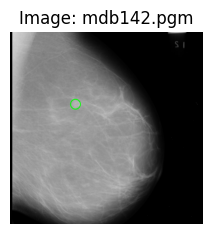

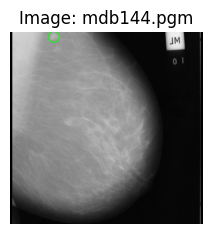

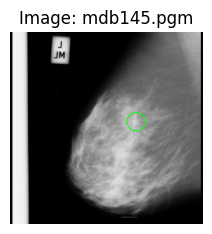

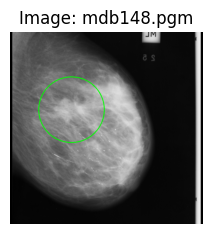

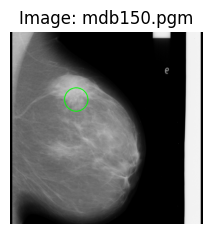

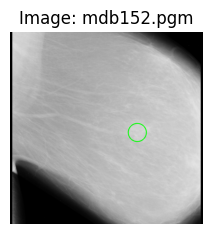

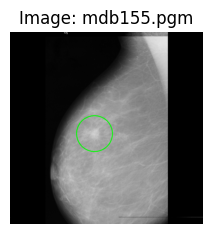

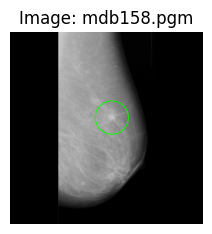

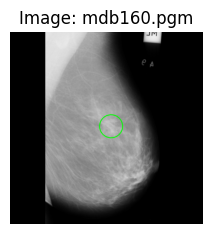

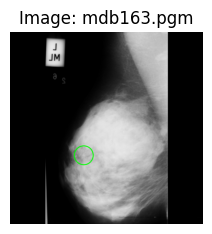

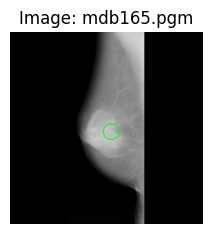

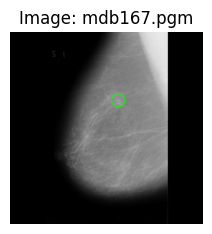

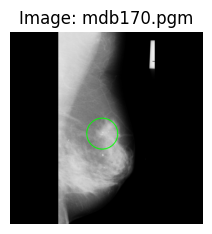

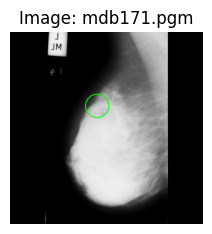

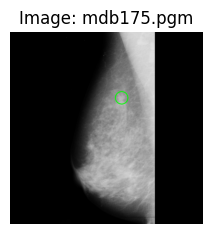

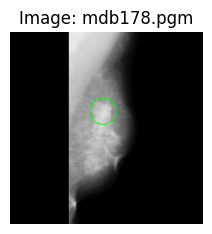

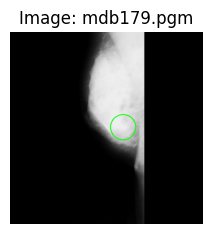

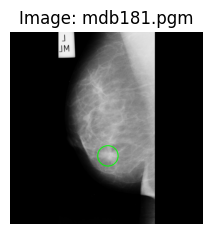

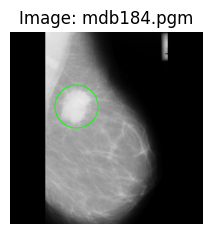

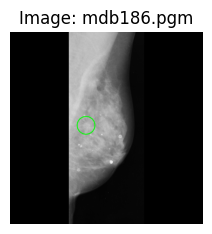

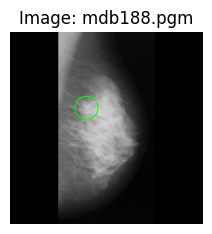

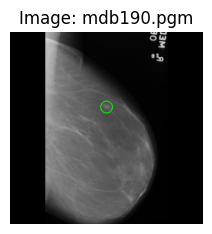

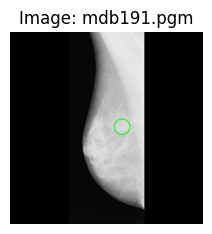

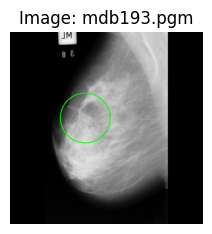

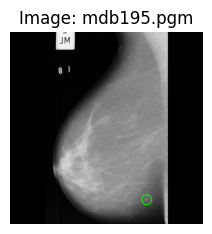

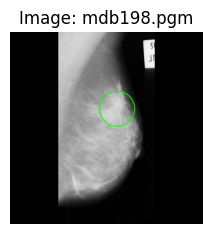

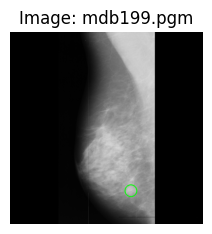

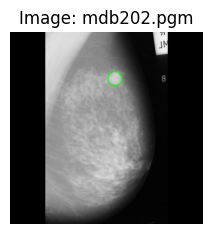

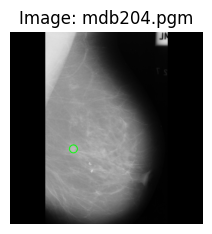

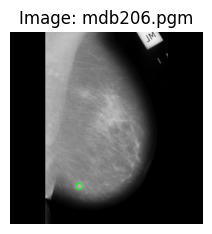

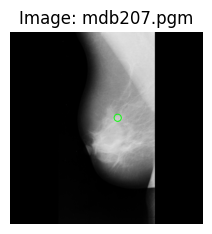

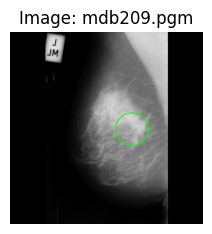

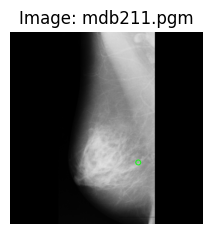

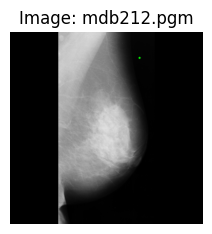

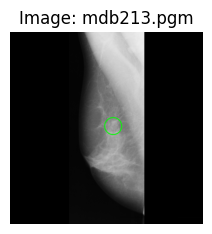

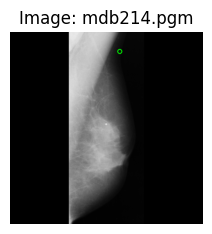

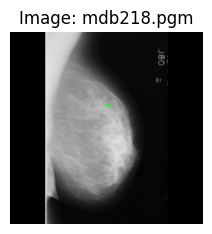

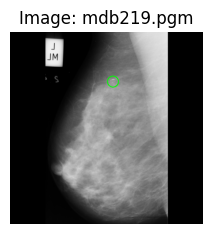

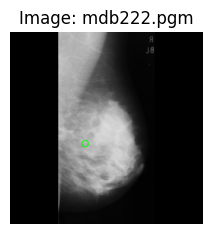

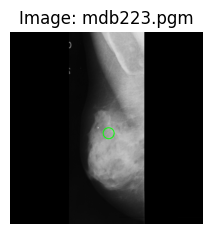

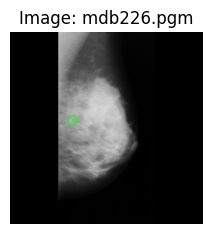

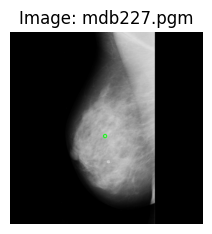

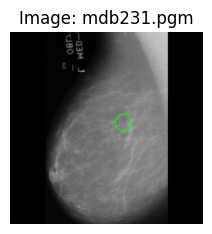

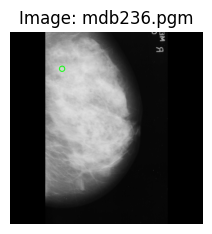

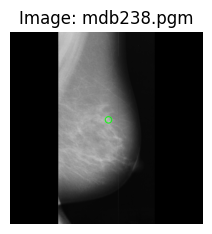

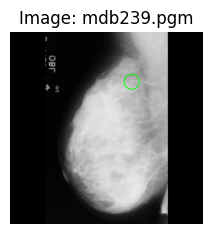

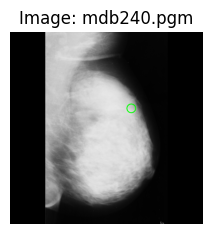

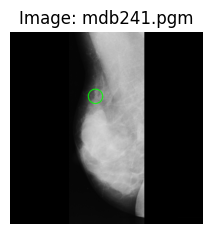

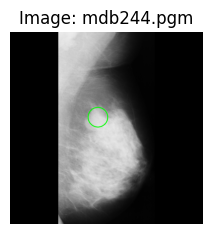

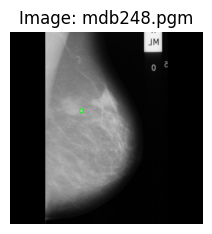

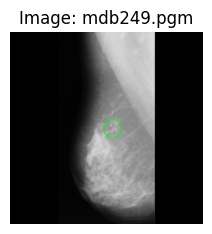

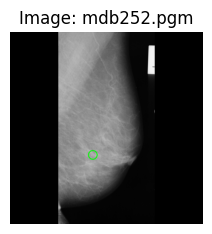

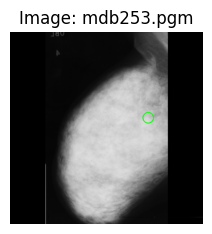

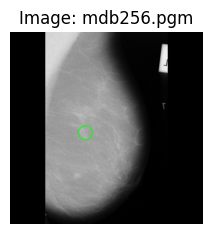

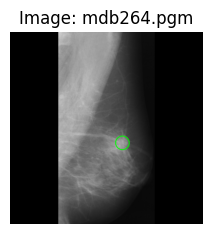

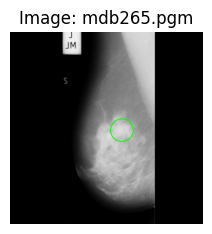

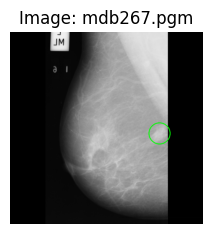

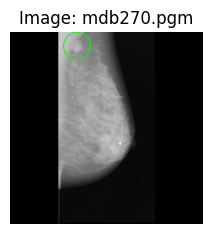

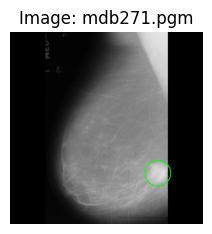

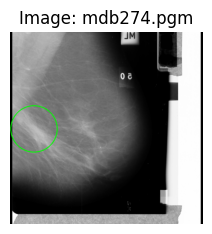

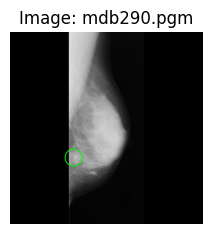

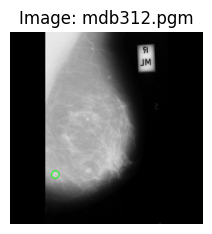

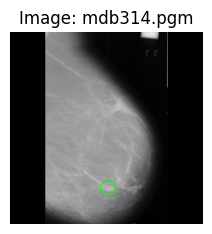

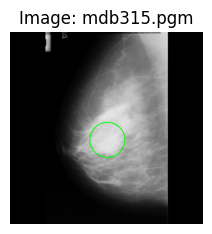

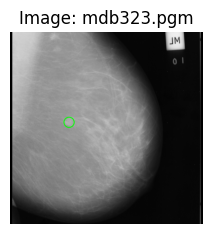

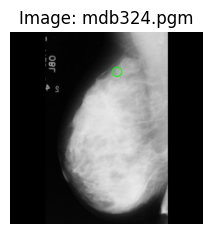

In [31]:
## 1. Load the DataFrame Correctly
# Use sep="\s+" to handle variable spaces, which is more robust.
# Provide column names directly to avoid issues with headers.
col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
df = pd.read_csv('data2.txt', sep="\s+", names=col_names, header=None)
df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)


## 2. The Corrected Data Labeling Function
def data_labeling(img_files_path, info_df):
    """
    Processes images by looking up their data in the DataFrame using a unique ID.
    """
    # Loop through each file in the image directory
    for filename in os.listdir(img_files_path):
        if filename.endswith(".pgm"):
            # Extract the unique ID (e.g., 'mdb001') from the filename
            base_refnum = os.path.splitext(filename)[0]

            # Use the ID to look up the correct row in the DataFrame
            record = info_df[info_df['REFNUM'] == base_refnum]

            # Proceed only if a matching record was found
            if not record.empty:
                image_path = os.path.join(img_files_path, filename)

                # Load the image and prepare it for drawing
                img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)

                # Check if the record has coordinate data
                if pd.notna(record['X'].iloc[0]):
                    # Get data directly from the DataFrame columns
                    x = int(record['X'].iloc[0])
                    y = int(record['Y'].iloc[0])
                    r = int(record['RADIUS'].iloc[0])

                    # Draw the circle on the image
                    y_adj = 1024 - y  # Adjust y-coordinate
                    x = cv2.circle(img_rgb, (x, y_adj), r, (0, 255, 0), 3)

                    # You can now display it or save it
                    plt.figure(figsize=(2.5, 2.5))
                    plt.imshow(x)
                    plt.title(f"Image: {filename}")
                    plt.axis('off')
                    plt.show()


## 3. Call the Function Correctly
images_path = "all-mias"
# Pass the DataFrame to the function
data_labeling(images_path, df)

In [6]:

# --- 1. Set up Data Generators and Augmentation ---
# These will read images from your sorted folders
IMG_SIZE = (244, 244)
BATCH_SIZE = 32

# training the models based on different situation
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

validation_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
    'dataset_for_training/train/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary' # For 'cancer' vs 'normal'
)

validation_generator = validation_datagen.flow_from_directory(
    'dataset_for_training/validation/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# --- 2. Build the Model with Transfer Learning ---
# Load the pre-trained base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))

# Freeze the base model's layers
base_model.trainable = False

# Add our custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x) # Pool features to a manageable size
x = Dropout(0.5)(x) # Dropout to prevent overfitting
# The final prediction layer. 'sigmoid' is used for binary (0 or 1) classification.
predictions = Dense(1, activation='sigmoid')(x) 

model = Model(inputs=base_model.input, outputs=predictions)

# --- 3. Compile the Model ---
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# --- 4. Train the Model ---
# This is where the training happens. It might take a while!
history = model.fit(
    train_generator,
    epochs=20, # Number of times to go through the entire dataset
    validation_data=validation_generator
)

# --- 5. Save your trained model ---
model.save('breast_cancer_classifier_v1.h5')

Found 256 images belonging to 2 classes.
Found 64 images belonging to 2 classes.
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5906 - auc: 0.5097 - loss: 0.6826 - val_accuracy: 0.6406 - val_auc: 0.5000 - val_loss: 0.6621
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6377 - auc: 0.5328 - loss: 0.6574 - val_accuracy: 0.6406 - val_auc: 0.5000 - val_loss: 0.6539
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6434 - auc: 0.4842 - loss: 0.6527 - val_accuracy: 0.6406 - val_auc: 0.5000 - val_loss: 0.6530
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6164 - auc: 0.5298 - loss: 0.6676 - val_accuracy: 0.6406 - val_auc: 0.5000 - val_loss: 0.6533
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6839 - auc: 0.4494 - loss: 0.6294 - val_accuracy: 0.6406 - val_auc: 0.5000 - val_loss: 0.6538
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6609 - auc: 0.4503 - loss: 0.6447 - val_accuracy: 0.6406 - val_auc: 0.5870 - 

In [1]:
# def data_labeling(img_files, txt_path):
#     full_data = []
#     count_cancer = 0
#     img_coordinate = defaultdict(list)
#     pgm_index = 0
#     for i, filename in enumerate(sorted(os.listdir(img_files))):
#         if filename.endswith(".pgm"):
#             image_path = os.path.join(img_files, filename)
#             text = txt_file[i].strip()
#             pairing = {"Image": image_path, "Text": text}
#             pgm_index += 1
#             full_data.append(pairing)
#         else:
#             print(f"Not enough line in {filename}")
    
#     for pairing in full_data:
#         txt_value = pairing['Text']
#         img_value = pairing['Image']
#         img = cv2.imread(img_value)
#         txt_parts = txt_value.split()

#         if len(txt_parts) == 7 and img is not None:
#             count_cancer += 1
#             get_txt_data = txt_parts[4] + " - " + txt_parts[5] + " - " +txt_parts[6] + " - " +img_value[9:]
#             # print(" x      y    R")
#             print(get_txt_data)
            
#             x = int(txt_parts[4])
#             y = 1024 - int(txt_parts[5])
#             radius = int(txt_parts[6])

#             img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             cv2.circle(img_rgb, (x, y), radius, (0, 255, 0), 2)
#             # Create a mask for the circular ROI
#             mask = np.zeros(img_rgb.shape[:2], dtype=np.uint8)
#             cv2.circle(mask, (x, y), radius, 255, -1)  # Fill the circle with white
#             # Extract the circular ROI using the mask
#             roi = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
#             plt.imshow(img_rgb)
#             plt.show()

        
# # reading the Image file 
# images_path = "all-mias"

# # reading the txt file 
# txt_path = "data2.txt"
# with open(txt_path, "r") as file:
#     txt_file = file.readlines()[1:]

# data_labeling(images_path, txt_path)

In [2]:
# def data_labeling(img_files, txt_path):
#     full_data = []
#     count_cancer = 0
#     pgm_index = 0  # This will index into txt_file
    
#     # Loop through image files sorted by name
#     for filename in sorted(os.listdir(img_files)):
#         if filename.endswith(".pgm"):
#             image_path = os.path.join(img_files, filename)
            
#             # Check if we have a corresponding text line
#             if pgm_index < len(txt_file):
#                 text = txt_file[pgm_index].strip()
#             else:
#                 print(f"Warning: Not enough text lines for {filename}")
#                 text = ""  # or handle the error as needed
            
#             pairing = {"Image": image_path, "Text": text}
#             full_data.append(pairing)
#             pgm_index += 1  # increment only when a .pgm file is processed

#     # Process each pairing
#     for pairing in full_data:
#         txt_value = pairing['Text']
#         img_value = pairing['Image']
#         img = cv2.imread(img_value)
#         txt_parts = txt_value.split()

#         if len(txt_parts) == 7 and img is not None:
#             count_cancer += 1
#             get_txt_data = txt_parts[4] + " - " + txt_parts[5] + " - " + txt_parts[6] + " - " + img_value[9:]
#             print(get_txt_data)
            
#             x = int(txt_parts[4])
#             y = 1024 - int(txt_parts[5])
#             radius = int(txt_parts[6])

#             img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             cv2.circle(img_rgb, (x, y), radius, (0, 255, 0), 2)
#             mask = np.zeros(img_rgb.shape[:2], dtype=np.uint8)
#             cv2.circle(mask, (x, y), radius, 255, -1)
#             roi = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
#             # Optionally display the image:
#             # plt.imshow(img_rgb)
#             # plt.show()

# # Reading the image files
# images_path = "all-mias"

# # Reading the text file and skipping the header
# txt_path = "data2.txt"
# with open(txt_path, "r") as file:
#     txt_file = file.readlines()[1:]  # Skip the header line

# data_labeling(images_path, txt_path)


In [6]:
# ## FINDING THE REPEATED CORDINATION

# def data_labeling(img_files, txt_path):
#     full_data = []
#     count_cancer = 0
#     text_count = defaultdict(int)

#     # Reading image file paths and corresponding text values
#     for i, filename in enumerate(sorted(os.listdir(img_files))):
#         if filename.endswith(".pgm"):
#             image_path = os.path.join(img_files, filename)
#             text = txt_file[i].strip()

#             pairing = {"Image": image_path, "Text": text}
#             full_data.append(pairing)

#     # Iterate through the full_data, process each image and extract coordinates
#     for pairing in full_data:
#         txt_value = pairing['Text']
#         img_value = pairing['Image']
#         img = cv2.imread(img_value)
#         txt_parts = txt_value.split()
#         tokens = pairing['Text'].split()
#         txt_key = tokens[0]
#         text_count[txt_key] += 1
#     coordinates_dict = defaultdict(list)
    
#     for entry in full_data:
#         tokens = entry['Text'].split()
#         if len(tokens) > 3:
#             txt_key = tokens[0]  # Extract text key
#             # print(txt_key)
#             if text_count[txt_key] > 1:  # Only consider repeated text keys
#                 coords = list(map(int, tokens[-3:]))  # Extract last three as coordinates
#                 coordinates_dict[txt_key].append(coords)

#     for key, coords in coordinates_dict.items():
#         print(f"{key}: {coords}")

# # Reading the image file paths
# images_path = "all-mias"

# # Reading the txt file
# txt_path = "data2.txt"
# with open(txt_path, "r") as file:
#     txt_file = file.readlines()

# # Run the data labeling function
# data_labeling(images_path, txt_path)


   REFNUM BG CLASS SEVERITY      X      Y  RADIUS
0  mdb001  G  CIRC        B  535.0  425.0   197.0
1  mdb002  G  CIRC        B  522.0  280.0    69.0
2  mdb003  D  NORM      NaN    NaN    NaN     NaN
3  mdb004  D  NORM      NaN    NaN    NaN     NaN
4  mdb005  F  CIRC        B  477.0  133.0    30.0


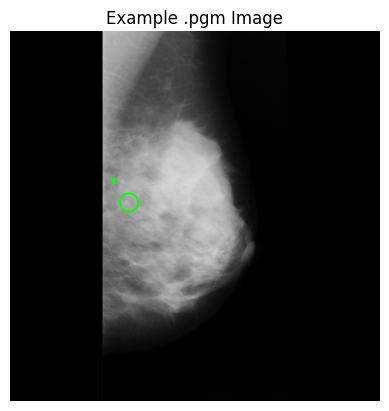

In [42]:
# # Read the image file
# img_file = "all-mias/mdb226.pgm"
# img_gray = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
# img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)

# # Read the text file
# with open("info.txt", "r") as file:
#     txt_lines = file.readlines()

# # Read the CSV file
# df = pd.read_csv("Info.txt", sep=" ").drop("Unnamed: 7", axis=1)
# print(df.head(5))

# # Example data: list of [x, y, radius]
# mdb144 = [[287, 610, 7], [329, 550, 25]]
# # Sort by the last element (assumed to be the radius)
# sorted_mdb = sorted(mdb144, key=lambda item: item[-1])

# # Draw a circle for each detection
# for x, y, r in sorted_mdb:
#     y_adj = 1024 - y  # adjust y-coordinate
#     cv2.circle(img_rgb, (x, y_adj), r, (0, 255, 0), 3)

# # Create a mask and region of interest using the first detection (if available)
# if sorted_mdb:
#     x, y, r = sorted_mdb[0]
#     y_adj = 1024 - y
#     mask = np.zeros(img_rgb.shape[:2], dtype=np.uint8)
#     cv2.circle(mask, (x, y_adj), r, 255, -1)
#     roi = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

# # Display the result
# plt.imshow(img_rgb, cmap='gray')
# plt.title("Example .pgm Image")
# plt.axis('off')  # Hide axis ticks
# plt.show()


In [3]:
# # reading the Image file 
# # img_files = glob.glob("all-mias")
# img_files_test = "all-mias/mdb226.pgm"
# # print(f"found {len(img_files)} .pmg images")

# # reading the txt file 
# txt_path = "info.txt"
# with open(txt_path, "r") as file:
#     txt_file = file.readlines()

# df = pd.read_csv('Info.txt', sep=" ").drop('Unnamed: 7',axis=1)
# df.head(5)

    
# img_t = cv2.imread(img_files_test, cv2.IMREAD_GRAYSCALE)
# img_rgb_t = cv2.cvtColor(img_t, cv2.COLOR_GRAY2RGB)
# # x, y, radius = 535, 425, 197
# # custom_list = {}
# mdb144 = [[287, 610, 7], [329, 550, 25], [531, 721, 8]]
# # mdb144 = [[233, 994, 29], [313, 540, 27]]
# # mdb144 = [[522, 280, 69]]


# if len(mdb144) == 1:
#     sorted_mdb = sorted(mdb144, key= lambda item: item[-1])
#     x, y, r = mdb144[0]
#     y = 1024 - y
#     cv2.circle(img_rgb_t, (x, y),r, (0, 255, 0), 2) 
#     mask = np.zeros(img_rgb_t.shape[:2], dtype=np.uint8)
#     cv2.circle(mask, (x, y), r, 255, -1)
#     roi = cv2.bitwise_and(img_rgb_t, img_rgb_t, mask=mask)

#     plt.imshow(img_rgb_t, cmap='gray')
#     plt.title("Example .pgm Image")
#     plt.axis('off')  # Hide axis ticks
#     plt.show()

# elif len(mdb144) == 2:
#     sorted_mdb = sorted(mdb144, key=lambda item: item[-1])
#     for i in range(len(sorted_mdb)):
#         x, y, r = sorted_mdb[i]
#         y = 1024-y
#         if len(sorted_mdb) > 1:
#             x2, y2, r2 = sorted_mdb[0]
#             y2 = 1024-y2
#     cv2.circle(img_rgb_t, (x, y),r, (0, 255, 0), 2) 
#     cv2.circle(img_rgb_t, (x2,y2), r2, (0, 255, 0), 2) 
#     mask = np.zeros(img_rgb_t.shape[:2], dtype=np.uint8)
#     cv2.circle(mask, (x, y), r, 255, -1)
#     roi = cv2.bitwise_and(img_rgb_t, img_rgb_t, mask=mask)

#     plt.imshow(img_rgb_t, cmap='gray')
#     plt.title("Example .pgm Image")
#     plt.axis('off')  # Hide axis ticks
#     plt.show()

# elif len(mdb144) == 3:
#     sorted_mdb = sorted(mdb144, key=lambda item: item[-1])
#     for i in range(len(sorted_mdb)):
#         x, y, r = sorted_mdb[i]
#         y = 1024-y
#         if len(sorted_mdb) > 1:
#             x2, y2, r2 = sorted_mdb[1]
#             y2 = 1024-y2
#             x3, y3, r3 = sorted_mdb[0]
#             y3 = 1024-y3
#     cv2.circle(img_rgb_t, (x, y),r, (0, 255, 0), 2) 
#     cv2.circle(img_rgb_t, (x2,y2), r2, (0, 255, 0), 2)
#     cv2.circle(img_rgb_t, (x3,y3), r3, (0, 255, 0), 2)
#     mask = np.zeros(img_rgb_t.shape[:2], dtype=np.uint8)
#     cv2.circle(mask, (x, y), r, 255, -1)
#     roi = cv2.bitwise_and(img_rgb_t, img_rgb_t, mask=mask)

#     plt.imshow(img_rgb_t, cmap='gray')
#     plt.title("Example .pgm Image")
#     plt.axis('off')  # Hide axis ticks
#     plt.show()


In [4]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# # Read image file
# img_files_test = "all-mias/mdb144.pgm"
# img_t = cv2.imread(img_files_test, cv2.IMREAD_GRAYSCALE)
# img_rgb_t = cv2.cvtColor(img_t, cv2.COLOR_GRAY2RGB)

# # Example mdb144 data (x, y, radius)
# mdb144 = [[233, 994, 29], [313, 540, 27]]

# # Sort list by the y-coordinate (second element)
# sorted_mdb = sorted(mdb144, key=lambda item: item[1])

# # Process the first sublist
# if len(sorted_mdb) >= 1:
#     x, y, r = sorted_mdb[0]
#     y_adj = y - 1024  # Adjust y-coordinate if necessary
#     cv2.circle(img_rgb_t, (x, y_adj), r, (0, 255, 0), 2)
#     # Overlay coordinate text
#     cv2.putText(img_rgb_t, f"({x}, {y_adj})", (x, y_adj), 
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# # Process the second sublist if available
# if len(sorted_mdb) >= 2:
#     x2, y2, r2 = sorted_mdb[1]
#     y2_adj = y2 - 1024  # Adjust y-coordinate if necessary
#     cv2.circle(img_rgb_t, (x2, y2_adj), r2, (0, 255, 0), 2)
#     # Overlay coordinate text
#     cv2.putText(img_rgb_t, f"({x2}, {y2_adj})", (x2, y2_adj), 
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# # Create a mask using the first circle's parameters (if needed)
# mask = np.zeros(img_rgb_t.shape[:2], dtype=np.uint8)
# cv2.circle(mask, (x, y - 1024), r, 255, -1)
# roi = cv2.bitwise_and(img_rgb_t, img_rgb_t, mask=mask)

# # Display the result
# plt.imshow(img_rgb_t)
# plt.title("Example .pgm Image")
# plt.axis('off')  # Hide axis ticks
# plt.show()
